In [1]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re
from datasets import load_dataset
import os
from diversity import compression_ratio, ngram_diversity_score, extract_patterns, get_pos, pos_patterns, token_patterns, self_repetition_score
import json
from collections import Counter
from random import shuffle

tqdm.pandas()

import matplotlib.pyplot as plt
# import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(14,10)}, font_scale=2)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)
np.set_printoptions(precision=3)

In [2]:
def calc_cr_nds_sr(responses):
    cr = compression_ratio(responses, 'gzip')
    nds = ngram_diversity_score(responses, 4)
    #CR-POS
    joined_pos, tuples = get_pos(responses)
    # ngrams_pos = token_patterns(joined_pos, 5, 10)
    cr_pos = compression_ratio(joined_pos, 'gzip')
    srep = self_repetition_score(responses, verbose=False)
    return cr, cr_pos, nds, srep

def calc_diversity(df, num_shuffles=10):
    '''
    Randomly assigns personas with prompts, calculates metrics over responses for these
    pairings, then calculates mean and S.D over 10 different random pairings
    '''
    random.seed(1)
    crs = []
    ndss = []
    crs_pos = []
    sreps = []
    new_df = df.set_index(['persona_id', 'prompt_id'])
    for _ in tqdm(range(num_shuffles)):
        # Get random personas paired with every prompt
        persona_ids_shuffled = [i for i in range(100)]
        random.shuffle(persona_ids_shuffled)
        prompt_ids = [i for i in range(100)]
        pairs = list(zip(persona_ids_shuffled, prompt_ids))
        responses = new_df.loc[pairs, 'response'].values.tolist()
        
        # Calculate metrics
        cr, cr_pos, nds, srep = calc_cr_nds_sr(responses)
    
        crs.append(cr)
        ndss.append(nds)
        crs_pos.append(cr_pos)
        sreps.append(srep)
    
    print(f"CR: {np.round(np.mean(crs),2)} ± {np.round(np.std(crs),2)}\nCR-POS: {np.round(np.mean(crs_pos),2)} ± {np.round(np.std(crs_pos),2)}\nNDS: {np.round(np.mean(ndss),2)} ± {np.round(np.std(ndss),2)}\nSelf-rep:{np.round(np.mean(sreps),2)} ± {np.round(np.std(sreps),2)}")

## Dolly human responses

In [3]:
with open('../data/sample_personas.txt', 'r') as f:
    personas = [x.strip() for x in f.readlines()]
dolly = load_dataset("databricks/databricks-dolly-15k")["train"].filter(lambda row: row['category']=='creative_writing').to_pandas()
sample = pd.read_csv('../data/dolly_creative_prompts_sample.tsv', sep='\t')
sample['response'] = sample['index'].apply(lambda x: dolly.loc[x, 'response'])
sample['prompt_id'] = [i for i in range(len(sample))]
prompts = sample['instruction'].values.tolist()
human_responses = sample['response'].values.tolist()

In [4]:
cr = compression_ratio(human_responses, 'gzip')
nds = ngram_diversity_score(human_responses, 4)
joined_pos, tuples = get_pos(human_responses)
# ngrams_pos = token_patterns(joined_pos, 5, 10)
cr_pos = compression_ratio(joined_pos, 'gzip')
# rouge = homogenization_score(human_responses, 'rougel', verbose=False)
# bleu = homogenization_score(human_responses, 'bleu', verbose=False)
srep = self_repetition_score(human_responses)
# print(f"CR: {np.round(cr,2)}\nNDS: {np.round(nds,2)}\nCR-POS: {np.round(cr_pos,2)}\nHS-RougeL: {np.round(rouge,2)}\nself-bleu: {np.round(bleu,2)}\nSelf-rep: {np.round(srep, 2)}")
print(f"CR: {np.round(cr,2)}\nNDS: {np.round(nds,2)}\nCR-POS: {np.round(cr_pos,2)}\nSelf-rep: {np.round(srep, 2)}")

Calculating self-repetition score: 100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 78062.61it/s]

CR: 2.51
NDS: 3.03
CR-POS: 4.93
Self-rep: 0.55


## Llama-70B

In [5]:
# No persona, no cutoff
np70_df = pd.read_csv('../output/llama-temp0.7/llama70b-np/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
np70_df['response'] = np70_df.response.apply(lambda x: x.strip())
np70_df = np70_df.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')
cr, cr_pos, nds, srep = calc_cr_nds_sr(np70_df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.76
CR-POS: 5.72
NDS: 2.87
Self-rep: 1.96


In [6]:
# No persona with cutoff
npc70_df = pd.read_csv('../output/llama-temp0.7/llama70b-cutoff-np/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
npc70_df['response'] = npc70_df.response.apply(lambda x: x.strip())
npc70_df = npc70_df.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')
cr, cr_pos, nds, srep = calc_cr_nds_sr(npc70_df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.57
CR-POS: 5.1
NDS: 3.1
Self-rep: 0.44


In [7]:
persona70_df = pd.read_csv('../output/llama-temp0.7/llama70b-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
persona70_df['response'] = persona70_df.response.apply(lambda x: x.strip())
persona70_df = persona70_df.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')
calc_diversity(persona70_df, num_shuffles=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:24<00:00,  5.64s/it]

CR: 2.7 ± 0.02
CR-POS: 5.39 ± 0.03
NDS: 2.83 ± 0.01
Self-rep:2.58 ± 0.11


In [8]:
# Persona plus cutoff
personac70_df = pd.read_csv('../output/llama-temp0.7/llama70b-cutoff-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
personac70_df['response'] = personac70_df.response.apply(lambda x: x.strip())
calc_diversity(personac70_df, num_shuffles=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:41<00:00,  5.82s/it]

CR: 2.52 ± 0.02
CR-POS: 5.04 ± 0.03
NDS: 3.08 ± 0.02
Self-rep:0.72 ± 0.11


In [10]:
# Persona plus cutoff plus coarse personas
persona70_df_coarse = pd.read_csv('../output/coarse/llama-cutoff-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
persona70_df_coarse['response'] = persona70_df_coarse.response.apply(lambda x: x.strip())
persona70_df_coarse = persona70_df_coarse.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')
calc_diversity(persona70_df_coarse, num_shuffles=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:33<00:00,  5.74s/it]

CR: 2.51 ± 0.02
CR-POS: 5.06 ± 0.04
NDS: 3.09 ± 0.02
Self-rep:0.61 ± 0.08


## Deepseek

In [39]:
# No persona, no cutoff
deep_npnc = pd.read_csv('../output/deepseek-np/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_npnc['response'] = deep_npnc.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(deep_npnc['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.36
CR-POS: 5.5
NDS: 3.15
Self-rep: 0.86


In [17]:
# No persona, cutoff
deep_npc = pd.read_csv('../output/deepseek-np-cutoff/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_npc['response'] = deep_npc.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(deep_npc['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.29
CR-POS: 4.95
NDS: 3.32
Self-rep: 0.11


In [16]:
# Persona cutoff
deep_pc = pd.read_csv('../output/deepseek-cutoff-persona/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_pc['response'] = deep_pc.response.apply(lambda x: x.strip())
deep_pc = deep_pc.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(deep_pc, 100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:14<00:00,  5.54s/it]

CR: 2.2 ± 0.02
CR-POS: 4.71 ± 0.03
NDS: 3.38 ± 0.01
Self-rep:0.09 ± 0.04


In [15]:
# Coarse persona cutoff
deep_pc_coarse = pd.read_csv('../output/coarse/deepseek-cutoff-persona/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_pc_coarse['response'] = deep_pc_coarse.response.apply(lambda x: x.strip())
deep_pc_coarse = deep_pc_coarse.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(deep_pc_coarse,100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:37<00:00,  5.77s/it]

CR: 2.22 ± 0.02
CR-POS: 4.77 ± 0.04
NDS: 3.37 ± 0.02
Self-rep:0.09 ± 0.04


In [16]:
deep_pc_coarse.sample(5)

,prompt_id,persona_id,response
8537,37,85,"""Wow, that’s a tough one! Personally, I think it depends on taste, but names like Da Vinci, Van Gogh, and Michelangelo always come up for their iconic works. More recently, Picasso and Frida Kahlo changed the game too. Oh, and Basquiat’s modern stuff is wild! Artists like them pushed boundaries and shaped culture—but honestly, ‘best’ is super subjective. Who’s *your* favorite? Maybe we can geek out over some art together sometime!"""
9137,37,91,"As a K9 trainer, my focus is on discipline, skill, and results—traits shared by history’s finest. For me, the real ""artists"" are the working dogs and handlers who’ve saved lives, from war zones to disaster sites. But if we’re talking traditional art, give me the raw power of Michelangelo’s sculptures or the precision of da Vinci—both remind me of a well-trained K9: flawless execution, unwavering focus, and timeless impact. Words: 80."
9186,86,91,"As a K9 trainer, I’d recommend the mountains. The terrain offers great physical and mental stimulation—perfect for a working dog like yours. Trails provide natural obedience and agility challenges, and cooler temps are safer for your K9. Beaches can overheat paws, and loose sand isn’t ideal for training. Plus, mountain air is refreshing after long drills. Pack extra water, check for wildlife, and enjoy the bond-building hikes. Stay mission-ready while unwinding! \n\n(90 words)"
9202,2,92,"As a translator, clarity and conciseness are key. When answering interview questions, follow these steps: \n\n1. **Understand the question**—ensure you grasp what’s being asked. \n2. **Structure your response**—use a clear format (e.g., STAR method for behavioral questions). \n3. **Be concise and relevant**—focus on key points without rambling. \n4. **Showcase your skills/traits**—align answers with the job’s requirements. \n5. **Maintain professionalism**—speak confidently yet humbly. \n\nRemember, effective communication (like translation) requires precision and adaptability—tailor your answers to the interviewer’s needs while staying authentic."
4797,97,47,"**As a die-hard Iowa Hawkeye wrestling fan**, I’ll tackle this philosophical question with the same intensity Coach Tom Brands brings to the mat. Wrestling isn’t just a sport—it’s a way of life, much like how Socrates and Aristotle saw philosophy. The ""good life"" isn’t just about winning (though that’s always nice); it’s about living with purpose, discipline, and excellence—values any Hawkeye wrestler would respect. \n\n---\n\n### **Socrates and Aristotle on the Good Life** \n\n#### **1. Socrates: Virtue is Knowledge, and the Unexamined Life Isn’t Worth Living** \nSocrates, much like a gritty 157-pounder, believed in questioning everything. He argued that the **good life** is achieved through **moral virtue**, which comes from **knowledge**. If you know what’s right, you’ll do what’s right—just like knowing proper positioning on the mat leads to escapes and reversals. \n\n- **Components of the Good Life (Socrates):** \n - **Self-examination** (asking tough questions, just like reviewing film after a loss). \n - **Pursuit of wisdom** (always learning, like studying new techniques). \n - **Moral integrity** (doing what’s right, even when no ref is watching). \n\nFor Socrates, the good life **isn’t innate**—it’s **learned through relentless self-improvement**, much like getting better in wrestling means drilling fundamentals daily. And yes, **anyone can achieve it**—if they’re willing to put in the work (Cael Sanderson didn’t go 159-0 by accident). \n\n#### **2. Aristotle: Eudaimonia (Flourishing) Through Reason and Excellence** \nAristotle, like the best Hawkeye champs, believed in balance. The good life (**eudaimonia**) isn’t just about winning; it’s about **fulfilling your potential through reason and virtuous action**. \n\n- **Components of the Good Life (Aristotle):** \n - **Rational activity** (using your mind wisely, like scouting opponents). \n - **Mo

In [19]:
personas[47]

'a die-hard Iowa Hawkeye wrestling fan and former wrestler'

In [26]:
deep_pc[(deep_pc.persona_id==33) & (deep_pc.prompt_id==55)]

,prompt_id,persona_id,response
3355,55,33,"Ram mimicked the speaker’s exact words, not understanding the shift from color repetition to a personal question. This illustrates a literal response without contextual comprehension—an intriguing cognitive behavior. In an exhibit, I’d use this to explore language processing, perhaps with interactive displays showing how humans and AI differentiate between rote repetition and meaningful interaction. Visual narratives would highlight the nuance of understanding context."


In [28]:
deep_npc[(deep_npc.prompt_id==55)]

,prompt_id,persona_id,response
55,55,-1,"Ram followed the pattern of repeating exact words until asked a direct question. Instead of repeating ""What's your name?"" as instructed, he answered it, breaking the repetition rule. The error lies in misunderstanding the task, as he was supposed to mimic the speaker verbatim, not respond to the question."


In [25]:
personas[33]

'a museum exhibit designer who specializes in illustrating scientific concepts through storytelling and visual narratives'

In [29]:
prompts[55]

"Ram was asked to repeat after the speaker. Speaker: Red, Ram: Red. Speaker: Blue, Ram: Blue. Speaker: Green, Ram: Green. Speaker: What's your name? , Ram: Ram\n\nWhat went wrong here?"

## Response length distribution

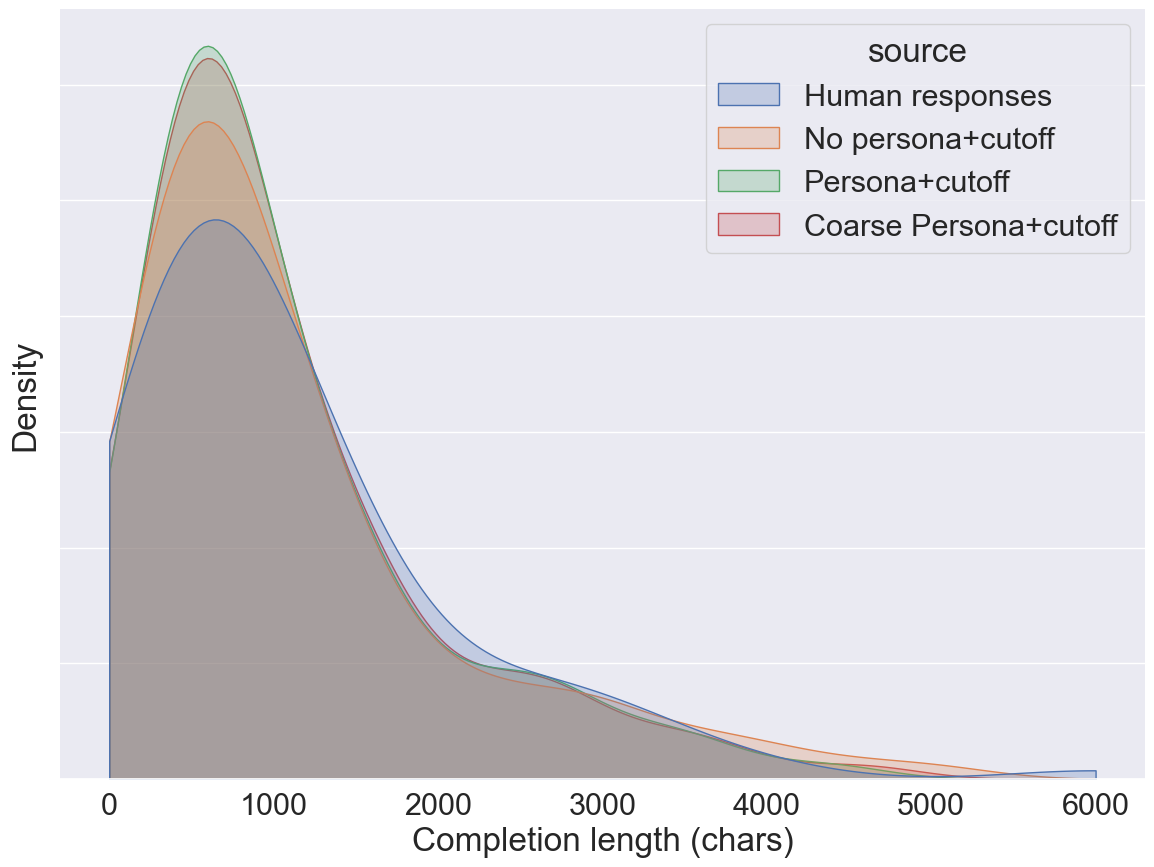

In [38]:
len_df = {'len': [], 'source':[]}

# Load all the human responses first.
len_df['len'] += sample['response'].apply(lambda x: len(x)).values.tolist()
len_df['source'] += ['Human responses' for _ in range(len(sample))]

for (df, source_name) in [(deep_npc,'No persona+cutoff'), (deep_pc, 'Persona+cutoff'), (deep_pc_coarse, 'Coarse Persona+cutoff')]:
    if df.shape[0]>100:
        df['len'] = df.response.apply(lambda x: len(x))
        len_df['len'] += df.loc[:, ['prompt_id', 'len']].groupby('prompt_id').mean().len.values.tolist()
    else:
        len_df['len'] += df['response'].apply(lambda x: len(x)).values.tolist()
    len_df['source'] += [source_name for _ in range(100)]
    
len_df=pd.DataFrame(len_df)

g = sns.kdeplot(len_df, x='len', hue='source', common_norm=False, fill=True, clip=[0,6000])
g.set_xlabel('Completion length (chars)')
g.set_ylabel('Density')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
g.set(yticklabels=[])
g.grid(axis='x')
# plt.legend([], [], frameon=False)
plt.show()

The above isn't right though, it makes the density look higher because i have more responses in the persona case 🤔

In [36]:
len_df

,len,source
0,975,Human responses
1,980,Human responses
2,623,Human responses
3,396,Human responses
4,1492,Human responses
...,...,...
395,[3800.55],Coarse Persona+cutoff
396,[653.46],Coarse Persona+cutoff
397,[4569.42],Coarse Persona+cutoff
398,[862.59],Coarse Persona+cutoff


In [37]:
deep_pc.loc[:, ['prompt_id', 'len']].groupby('prompt_id').mean().len.values.tolist()

[1066.84,
 991.09,
 631.55,
 437.74,
 1142.13,
 1568.77,
 643.73,
 2089.31,
 541.94,
 661.81,
 951.34,
 119.38,
 715.55,
 798.96,
 439.0,
 2256.33,
 1269.49,
 327.54,
 356.72,
 916.81,
 1550.64,
 710.65,
 556.05,
 935.2,
 534.59,
 248.2,
 1880.75,
 927.21,
 732.43,
 292.68,
 113.62,
 724.12,
 388.86,
 480.7,
 2598.67,
 545.76,
 2707.36,
 488.31,
 1887.19,
 428.24,
 1025.85,
 608.48,
 372.25,
 1078.37,
 3123.11,
 635.21,
 598.52,
 2760.98,
 1270.38,
 1240.37,
 2745.56,
 525.16,
 2631.05,
 1605.28,
 765.28,
 382.33,
 124.63,
 519.64,
 1542.57,
 644.72,
 723.88,
 484.8,
 2260.14,
 1429.27,
 222.91,
 381.39,
 1061.59,
 710.38,
 1273.15,
 450.35,
 769.24,
 319.04,
 3386.35,
 656.51,
 187.17,
 229.03,
 1303.35,
 1553.78,
 475.66,
 581.94,
 1531.25,
 726.58,
 1112.96,
 3457.66,
 285.58,
 2380.93,
 510.21,
 1540.16,
 436.07,
 1592.21,
 36.86,
 377.23,
 692.44,
 379.39,
 918.32,
 3722.85,
 668.93,
 4384.5,
 889.92,
 1136.98]